# This notebook renders the figures reported in the paper

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.utils import create_folder

RESULTS_DIR = '../results'

## Load Experiment Data

In [2]:
# Load data
path = RESULTS_DIR + '/label_error_trials.csv'
detection_df = pd.read_csv(path)

# Rename methods and columns for better readability
method_mapping = {
    'naive' : 'Ablation 1',
    'positive' : 'Ablation 2',
    'aum' : 'AUM',
    'entropy' : 'Entropy',
    'normalized_margins': 'Normalized Margins',
    'cross_val': 'Self-Confidence',
    'cleanlab': 'CleanLab',
}
col_mapping = {
    "noise_level": "Noise Level",
    "noise_type": "Noise Type",
}
detection_df['method'] = detection_df['method'].apply(lambda x: method_mapping[x])
detection_df = detection_df.rename(columns=col_mapping)
detection_df['Noise Type'] = detection_df['Noise Type'].apply(lambda x: x.capitalize())

## Render Method Comparisons

In [3]:
def plot_single_comparison(
        ax: plt.Axes,
        df: pd.DataFrame,
        method_x: str,
        method_y: str,
        hue_feature: str='Noise Level', 
        style_feature: str='Noise Type'
    ):
    # Plot identity line
    min_v = df[[method_x, method_y]].to_numpy().min()
    min_v = min_v - (100-min_v)*0.01  
    max_v = df[[method_x, method_y]].to_numpy().max()
    ax.plot([min_v, max_v], [min_v, max_v], color='grey', linestyle='--', alpha=0.5)

    # Plot data
    sns.scatterplot(
        ax=ax, data=df, x=method_x, y=method_y, 
        hue=hue_feature, style=style_feature, 
        alpha=0.6, s=30
    )

    # Set labels
    ax.set_xlabel(method_x)
    ax.set_ylabel(method_y)

    # hide legend
    ax.get_legend().remove()

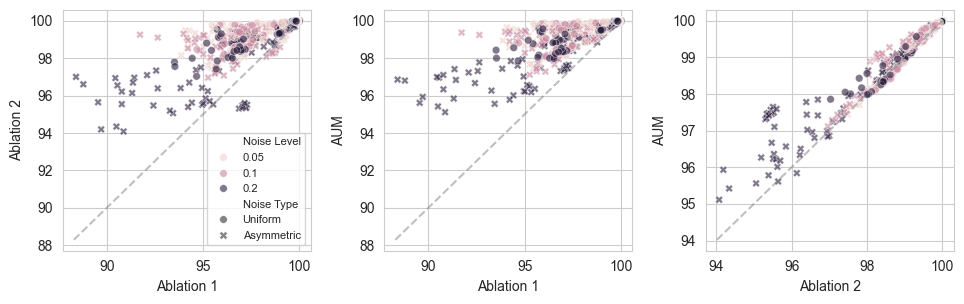

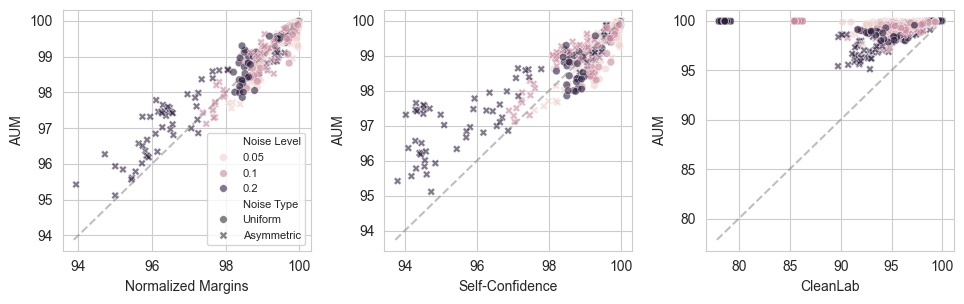

In [4]:
# Comparsion plots
comp_plots = dict(
    ablation = [
        ('Ablation 1', 'Ablation 2'),
        ('Ablation 1', 'AUM'),
        ('Ablation 2', 'AUM')
    ],

    other_methods = [
        ('Normalized Margins', 'AUM'),
        ('Self-Confidence', 'AUM'),
        ('CleanLab', 'AUM'),
    ],
)

# Pivot data so that each auroc value of a method is in a separate column
pivot_df = detection_df.pivot_table(  
    index=['ds_name', 'Noise Level', 'Noise Type', 'random_state'], 
    columns='method', values='auroc'
)

# Sort noise type so that "uniform" is first
pivot_df = pivot_df.reset_index()
pivot_df['Noise Type'] = pd.Categorical(
    pivot_df['Noise Type'], ['Uniform', 'Asymmetric']
) 

# Convert accuracy to percentage
pivot_df[list(method_mapping.values())] *= 100

_plot_size = 3
sns.set_style("whitegrid")
for comp_name, comparisons in comp_plots.items():
    fig, ax = plt.subplots(
        ncols=len(comparisons), 
        figsize=(len(comparisons)*(_plot_size+0.2),_plot_size)
    )
    fig.tight_layout(w_pad=2.5)
    
    for plot_idx, ((method_x, method_y), _ax) in enumerate(zip(comparisons, ax)):
        plot_single_comparison(_ax, pivot_df, method_x, method_y)

    ax[0].legend(prop={'size': 8})
    
    # Save as svg
    create_folder(RESULTS_DIR + '/figures')
    path = RESULTS_DIR + f"/figures/comparison_{comp_name}.svg"
    fig.savefig(path, format='svg', bbox_inches='tight')
    fig.show()

## Render Label Error Removal Experiments

In [5]:
path = RESULTS_DIR + '/improvement_trials.csv'
improvement_df = pd.read_csv(path)

method_mapping = {
    'aum' : 'AUM',
    'cross_val': 'Self-Confidence',
    'random': 'Random',
}
# Rename methods and columns for better readability
improvement_df['method'] = improvement_df['method'].apply(
    lambda x: method_mapping[x]
)

# Convert to multi-index
improvement_df = improvement_df.set_index(
    ['ds_name', 'method', 'noise_level', 'noise_type', 'random_state']
)

In [6]:
def plot_single_percentiles(
        ax: plt.Axes,
        df: pd.DataFrame,
        ds_name: str,
        noise_type: str,
        noise_level: float,
        percentages: bool=True
    ):
    methods = df.index.get_level_values('method').unique()
    max_percentile = 0.0

    # Plot mean and sed of the values
    for method in methods:
        sub_df = df.loc[(ds_name, method, noise_level, noise_type)]

        # Convert to percentage
        if percentages:
            sub_df['accuracy'] *= 100
            sub_df['percentile'] *= 100

        # Get zero accuracy
        zero_acc = sub_df.loc[sub_df['percentile'] == 0.0, 'accuracy'].mean()
        # Get max percentile
        max_percentile = max(max_percentile, sub_df['percentile'].max())

        # Average over random states
        x = sub_df['percentile'].unique() 
        mean = sub_df.groupby('percentile').mean().iloc[:, 0] - zero_acc
        sed = sub_df.groupby('percentile').sem().iloc[:, 0]

        # Plot mean and standard error of the mean
        ax.plot(x, mean, label=method)
        ax.fill_between(x, (mean-sed), mean+sed, alpha=0.2)
    
    # Plot zero line
    ax.axhline(0, color='grey', linestyle='-', alpha=0.5)

    # Plot line at noise level
    if noise_level > 0:
        ax.axvline(
            noise_level * 100 if percentages else noise_level,
            color='black', linestyle='--', alpha=0.5
        )

    # Set labels
    ax.set_xlabel('% Data Removed')
    ax.set_ylabel('Δ Accuracy in %')

    # Set limits
    ax.set_xlim(0, max_percentile)

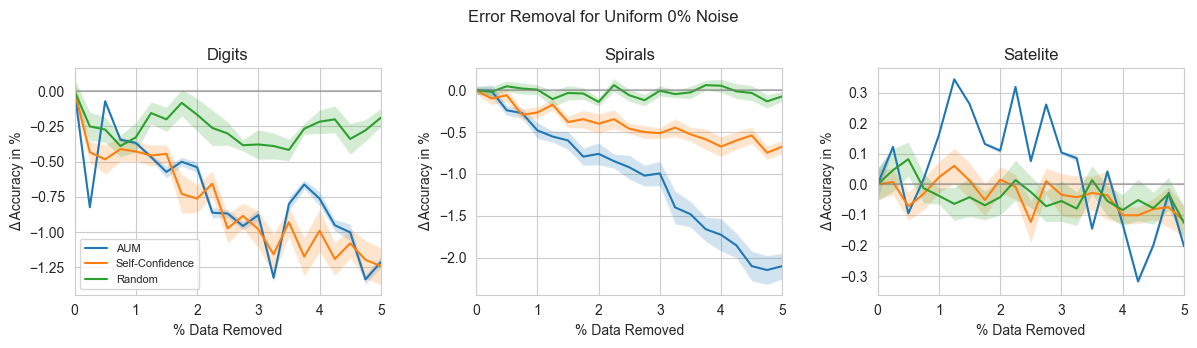

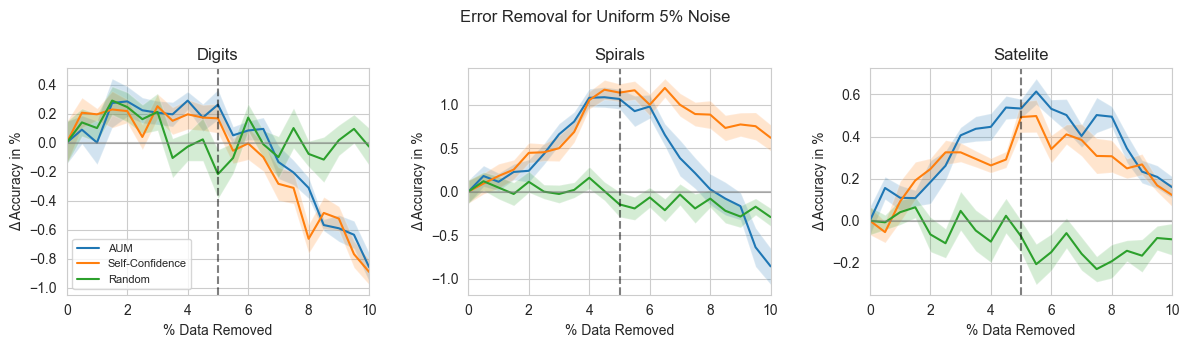

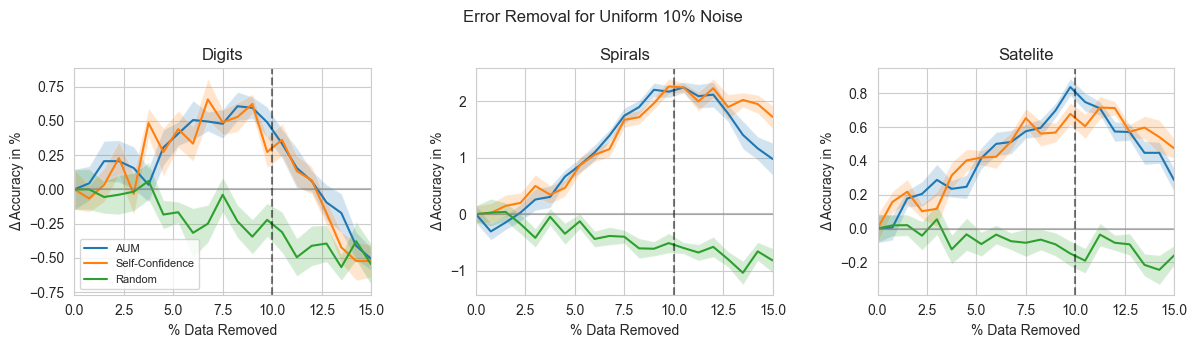

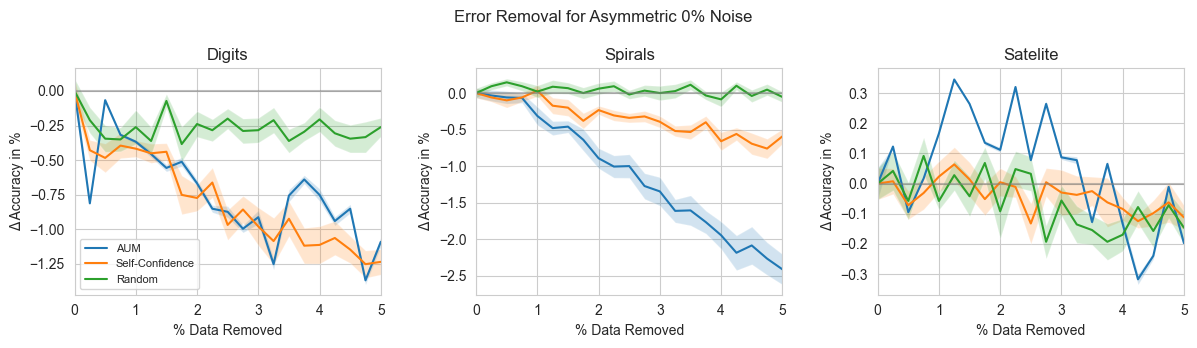

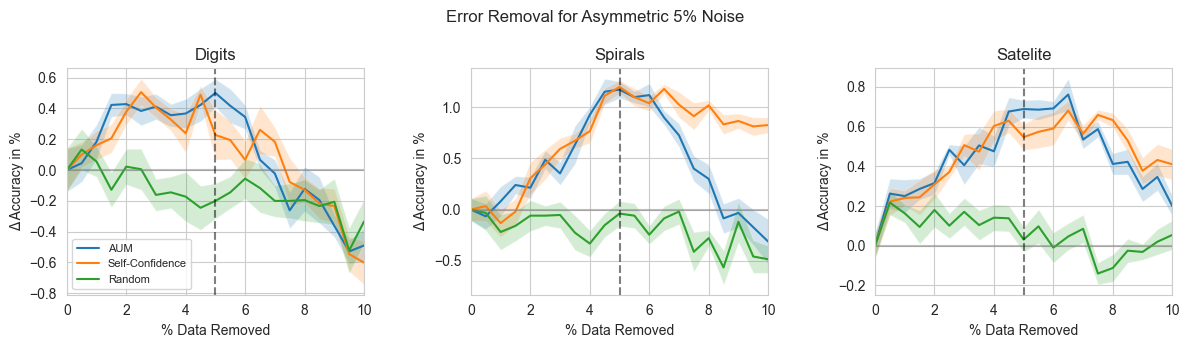

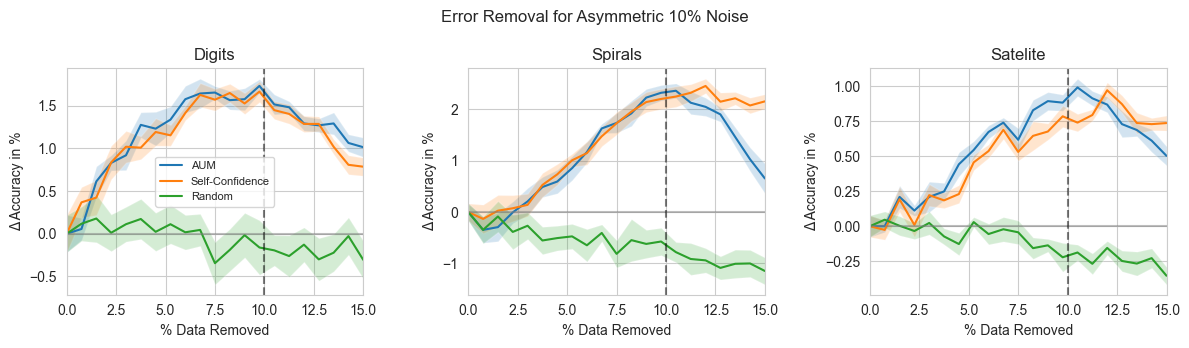

In [7]:

# Plot improvement
datasets = improvement_df.index.get_level_values('ds_name').unique()
noise_types = improvement_df.index.get_level_values('noise_type').unique()
noise_levels = improvement_df.index.get_level_values('noise_level').unique()
plot_accuracies = True

fig_scale = 3.5
fig_size = ((fig_scale + 0.5)*len(datasets), fig_scale)
sns.set_style("whitegrid")

for noise_type in noise_types:
    for noise_level in noise_levels:
        fig, ax = plt.subplots(ncols=len(datasets), figsize=fig_size)

        for ds_idx, ds_name in enumerate(datasets):
            plot_single_percentiles(
                ax[ds_idx], improvement_df, 
                ds_name, noise_type, noise_level,
                percentages=plot_accuracies
            )
            ax[ds_idx].set_title(ds_name.capitalize())

        create_folder(RESULTS_DIR + '/figures')
        path = (
            RESULTS_DIR +f"/figures/error_removal_{noise_type}_"
            f"{int(100*noise_level)}%.svg"
        )
        nl = int(100*noise_level)
        nt = noise_type.capitalize()
        
        ax[0].legend(prop={'size': 8})
        fig.suptitle(f"Error Removal for {nt} {nl}% Noise")
        fig.tight_layout(w_pad=2.5)
        plt.savefig(path, format='svg', bbox_inches='tight')
        plt.show()